# ClusterMap for STARmap V1_1020

In [1]:
from ClusterMap.clustermap import *
from anndata import AnnData
import tifffile
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io
import math
from tqdm import tqdm

### Read spots and dapi image

In [2]:
### set file folder
filepath='./datasets/STARmap_V1_1020/BY1/'

### read dapi: col, row, z
dapi = tifffile.imread(filepath+'BY1_dapi.tiff')

### read spots
spots = pd.read_csv(filepath+'BY1_raw.csv')
spots.columns=['gene_name','spot_location_1','spot_location_2','spot_location_3']

### convert gene_name to gene identity
genes=pd.DataFrame(spots['gene_name'].unique())
a1=list(genes[0])
gene=list(map(lambda x: a1.index(x)+1, spots['gene_name']))
spots['gene']=gene
spots['gene']=spots['gene'].astype('int')

# ### save gene annotation as genelist.csv
genes.to_csv(filepath+'genelist.csv', header=False, index=False)

In [3]:
### set radius parameters
xy_radius=40

Text(0.5, 1.0, 'raw data')

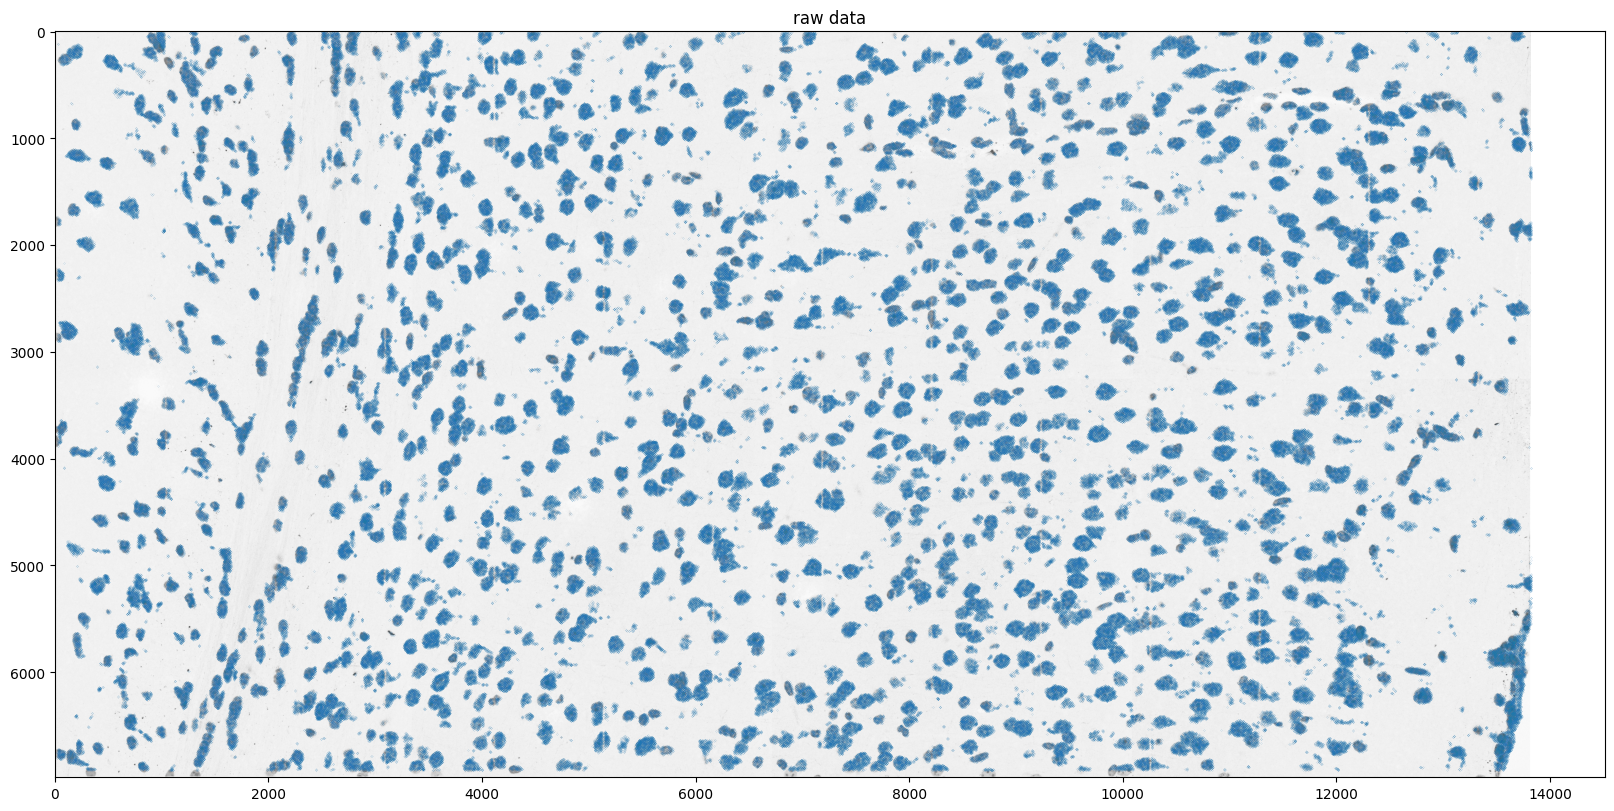

In [4]:
### overview
plt.figure(figsize=(20,20))
length=1000
plt.imshow(dapi,cmap='Greys')
plt.scatter(spots['spot_location_1'],spots['spot_location_2'],s=0.005)
plt.title('raw data')

### instantiate a model for all input data

In [5]:
num_gene=np.max(spots['gene'])

gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)
model = ClusterMap(spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=True)

If cell segmentation was performed before, jump to *Perform cell typing (based on Scanpy package)* part.

### split data into small tiles if input is large

In [6]:
### trim
img = dapi
window_size=2000
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 28 tiles


Text(0.5, 1.0, 'splitted tile: 15')

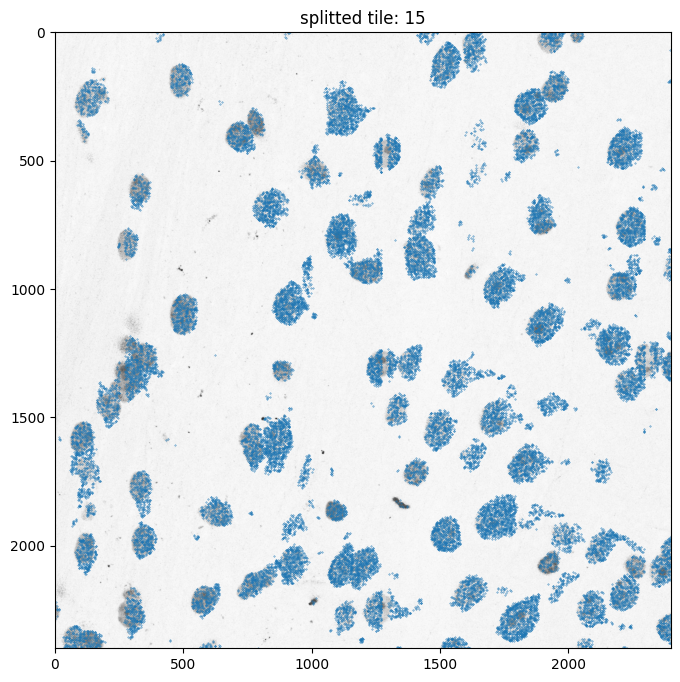

In [7]:
###plot a tile
tile_num=15
plt.figure(figsize=(8,8))
plt.imshow(out.loc[tile_num,'img'],cmap='Greys')

plt.scatter(out.loc[tile_num,'spots']['spot_location_1'],
            out.loc[tile_num,'spots']['spot_location_2'],s=0.1)
plt.title(f'splitted tile: {tile_num}')

### cell segmentation on each tile

tile: 0
After denoising, mRNA spots: 17036
Computing NGC coordinates


/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


After adding DAPI points, all spots:70937
DPC
  Compute spatial distance
  Compute genetic distance


70937it [02:25, 488.32it/s]


  Compute density rho and the nearest distance


70937it [00:45, 1554.70it/s] 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  7.90it/s]


  Find cell number:85.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70937/70937 [00:00<00:00, 443240.43it/s]


Postprocessing


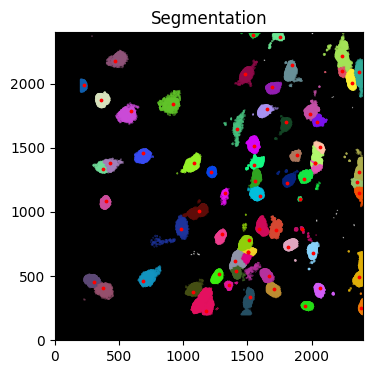

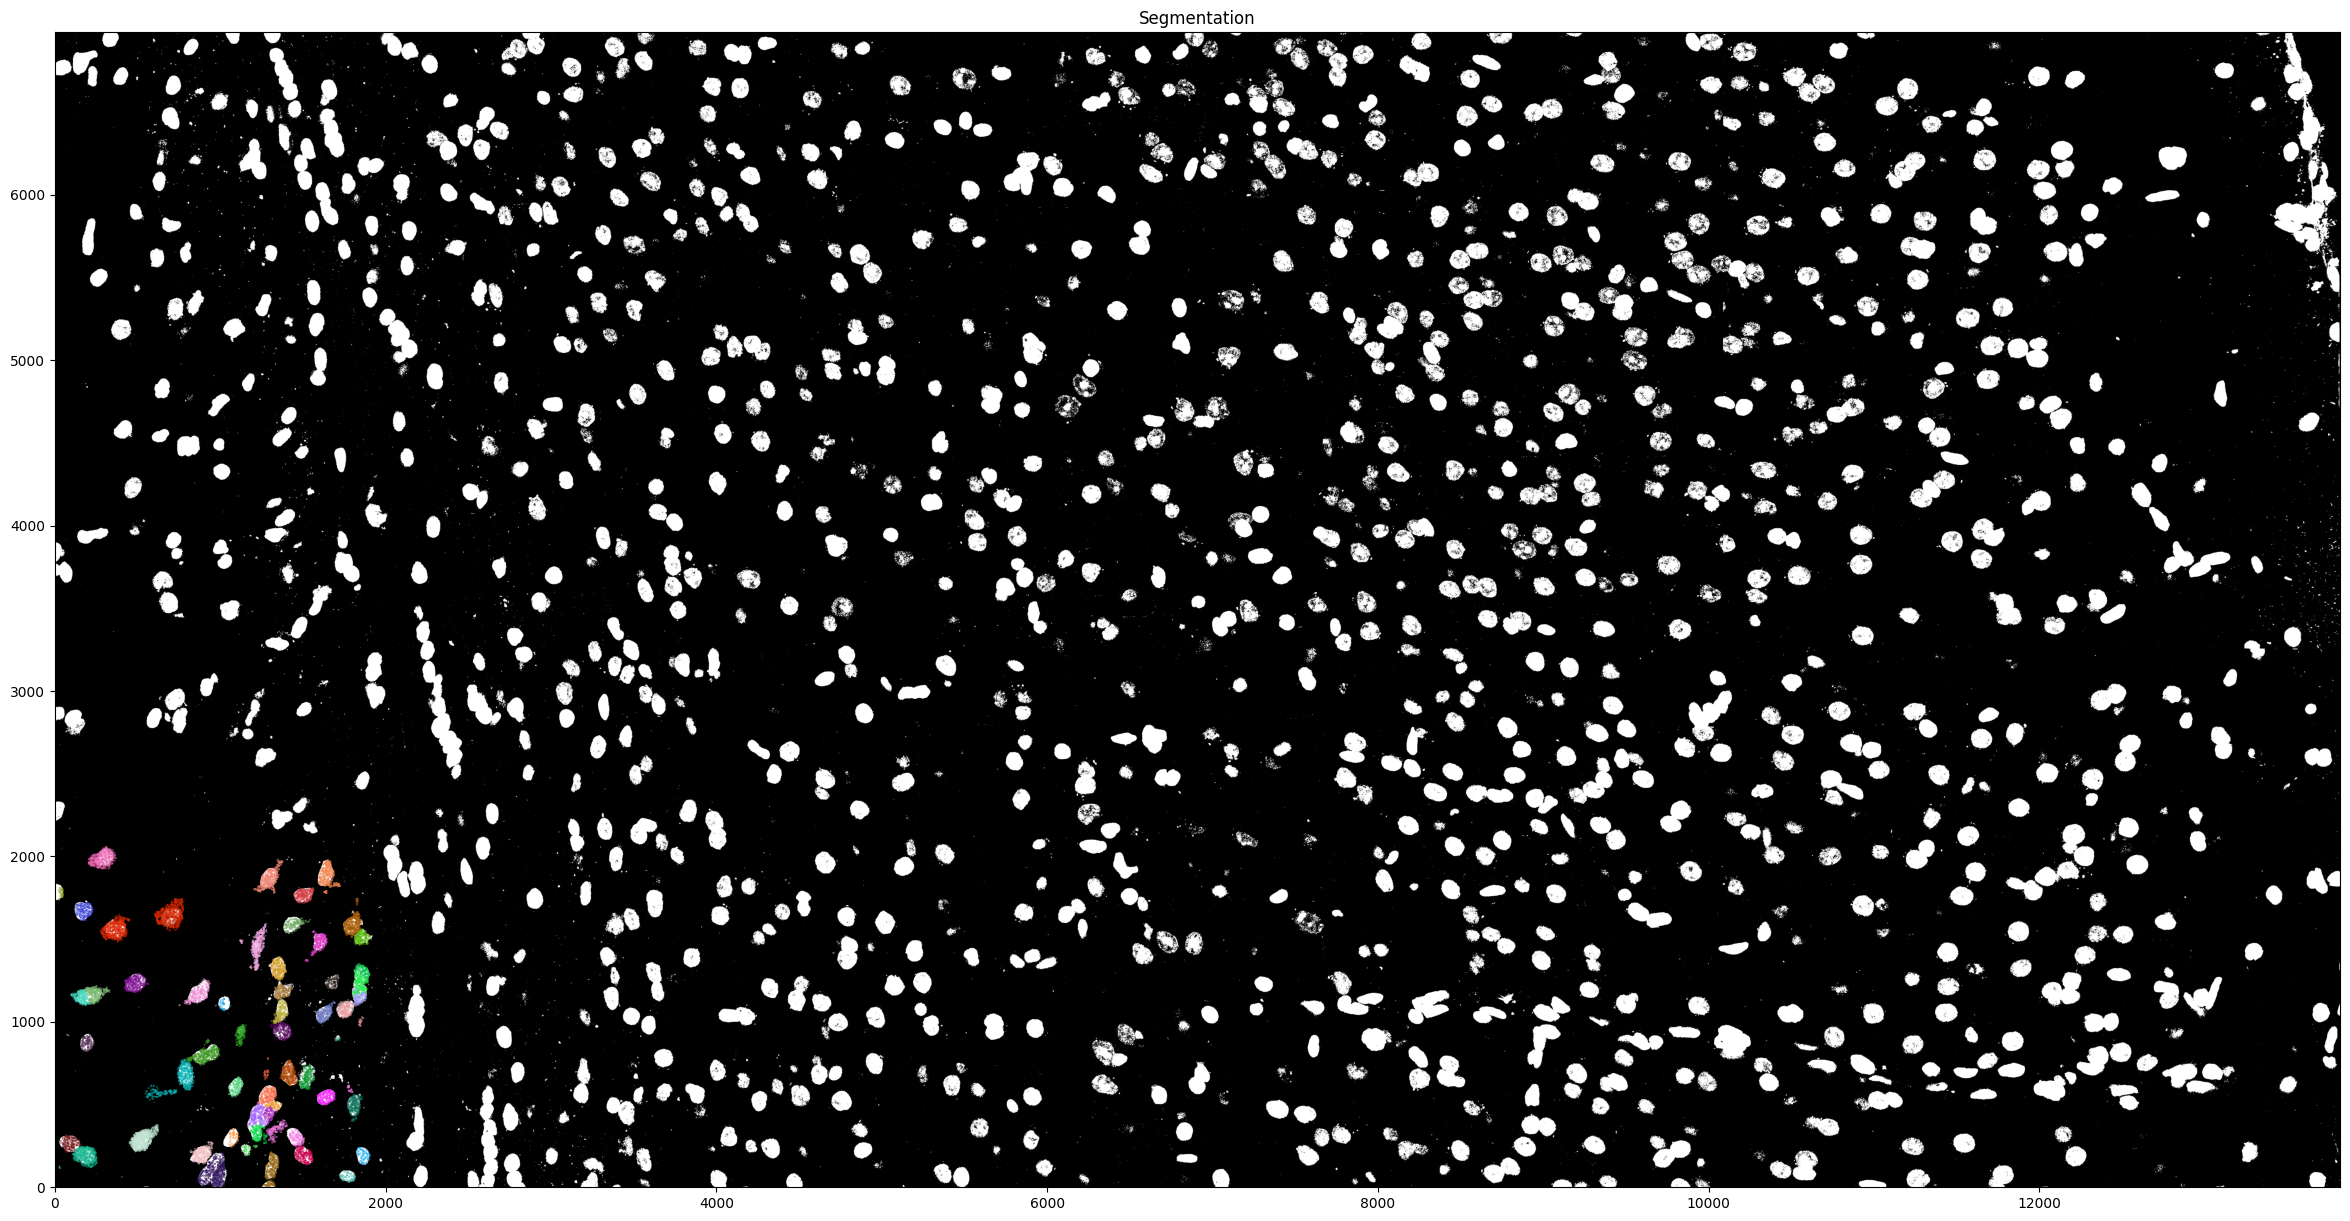

tile: 1
After denoising, mRNA spots: 26267
Computing NGC coordinates


/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


After adding DAPI points, all spots:100151
DPC
  Compute spatial distance
  Compute genetic distance


100151it [04:28, 372.82it/s]


  Compute density rho and the nearest distance


In [ ]:
%%time

### process each tile
pct_filter=0
model.spots['clustermap']=-1

for tile_num in range(out.shape[0]):
    print(f'tile: {tile_num}')
    spots_tile=out.loc[tile_num,'spots']
    dapi_tile=out.loc[tile_num,'img']

    ### instantiate model
    model_tile = ClusterMap(spots=spots_tile, dapi=dapi_tile, gene_list=gene_list, num_dims=num_dims,
                   xy_radius=xy_radius,z_radius=0,fast_preprocess=False)

    ###preprocessing
    model_tile.preprocess(dapi_grid_interval=3,pct_filter=pct_filter)

    # ### segmentation
    model_tile.min_spot_per_cell=5
    model_tile.segmentation(cell_num_threshold=0.07,dapi_grid_interval=3,add_dapi=True,use_genedis=True)

    # ### plot cell segmentation results in spots (colored by cells)
    model_tile.plot_segmentation(figsize=(4,4),s=0.05,plot_with_dapi=True,plot_dapi=True, show=False)
    plt.scatter(model_tile.cellcenter_unique[:,1],model_tile.cellcenter_unique[:,0],c='r',s=3)

    # ### stitch tiles together
    model.stitch(model_tile,out,tile_num)
    model.plot_segmentation(figsize=(30,15),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
    plt.show()

In [ ]:
model.plot_segmentation(figsize=(30,15),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
plt.scatter(model.cellcenter_unique[:,1],model.cellcenter_unique[:,0],c='r',s=20)
plt.show()

### Save cell segmentation results

In [16]:
path_save = filepath+'spots_all.csv'
model.save_segmentation(path_save)

### Perform cell typing (based on Scanpy package)

In [6]:
###read in saved cell segmentation results
path_save = filepath+'spots_all.csv'
savespots=pd.read_csv(path_save)
model.spots=savespots

In [7]:
cellid='clustermap'
geneid='gene'
num_gene=np.max(spots['gene'])
gene_list=np.arange(1,num_gene+1)
num_dims=len(dapi.shape)

In [8]:
### create adata, saved in model.cell_adata
model.create_cell_adata(cellid,geneid,gene_list,genes,num_dims)

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


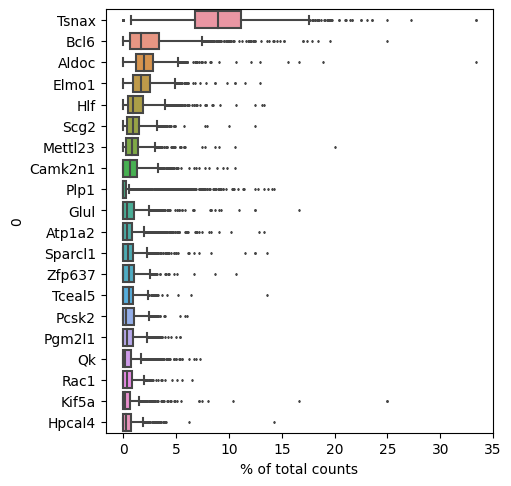

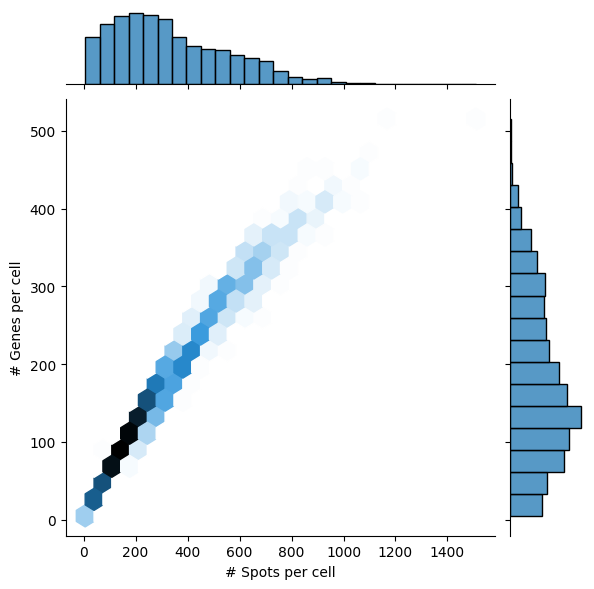

In [9]:
model.cell_preprocess()

Since the number of cells in one sample is relatively small, we apply a main-level to sub-level clustering strategy here to identify reliable cell types.

Main-level cluster

In [11]:
model.cell_typing(cluster_method='leiden',n_clusters=15,resol=1.5)

clustering method: leiden
Leiden clustering
Get 13 clusters


/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


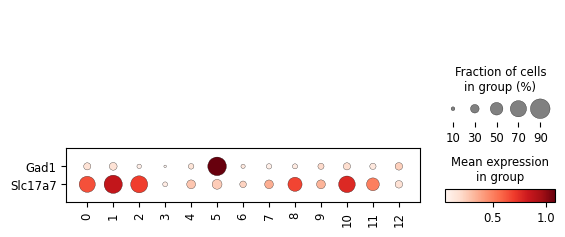

In [12]:
cluster_pl=model.plot_cell_typing(umap=False,
                                  heatmap=False,
                                  print_markers=False,
                                  celltypemap=False)
marker_genes=["Gad1","Slc17a7"]
sc.pl.dotplot(model.cell_adata, marker_genes, groupby='cell_type',swap_axes=True);

From the dotplot, we find that cluster 0,1,2,8,10 are Slc17a7 positive so we annotate them as excitatory neurons. Cluster 5 is Gad1 positive so we annotate it as inhibitory neuron.

In [13]:
merge_list = [[0,1,2,8,10],[3,4,6,7,9,11,12]]

model.merge_multiple_clusters(merge_list)

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


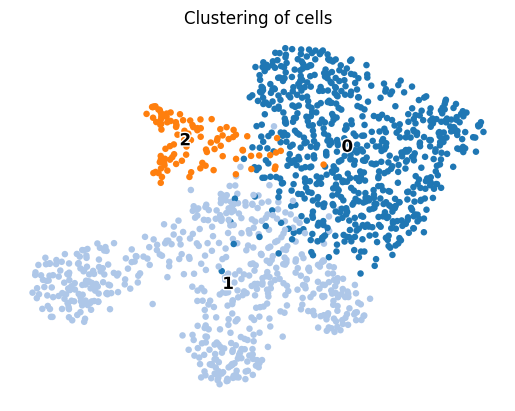

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:661: RuntimeWarning: invalid value encountered in divide
  return n_nonzero / X.shape[0]
/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:661: RuntimeWarning: invalid value encountered in divide
  return n_nonzero / X.shape[0]
/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:661: RuntimeWarning: invalid value encountered in divide
  return n_nonzero / X.shape[0]


0 ['Pcsk2', 'Pgm2l1', 'Slc17a7', 'Arc', 'Nrgn']
1 ['Plp1', 'Qk', 'Bcl6', 'Apod', 'Ptgds']
2 ['Gad1', 'Scg2', 'Elmo1', 'Tsnax', 'Gad2']


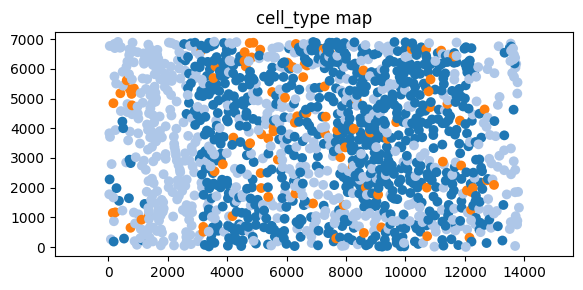

In [14]:
cluster_pl=model.plot_cell_typing(umap=True,
                                  heatmap=False, 
                                  print_markers=True,
                                  celltypemap=True)
# cluster_pl=model.plot_cell_typing()

Sub-level clustering

1. Excitatory neurons

In [15]:
model.exci_adata=model.cell_adata[model.cell_adata.obs['cell_type']==0,:]

In [16]:
model.cell_typing(use_adata=model.exci_adata,
                  cluster_method='leiden',
                  resol=1)

Trying to set attribute `.obs` of view, copying.


clustering method: leiden
Leiden clustering
Get 6 clusters


/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


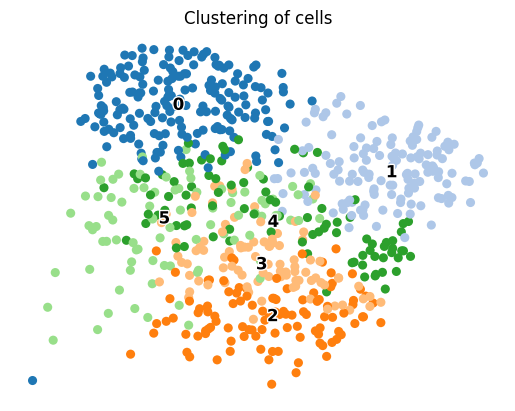

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


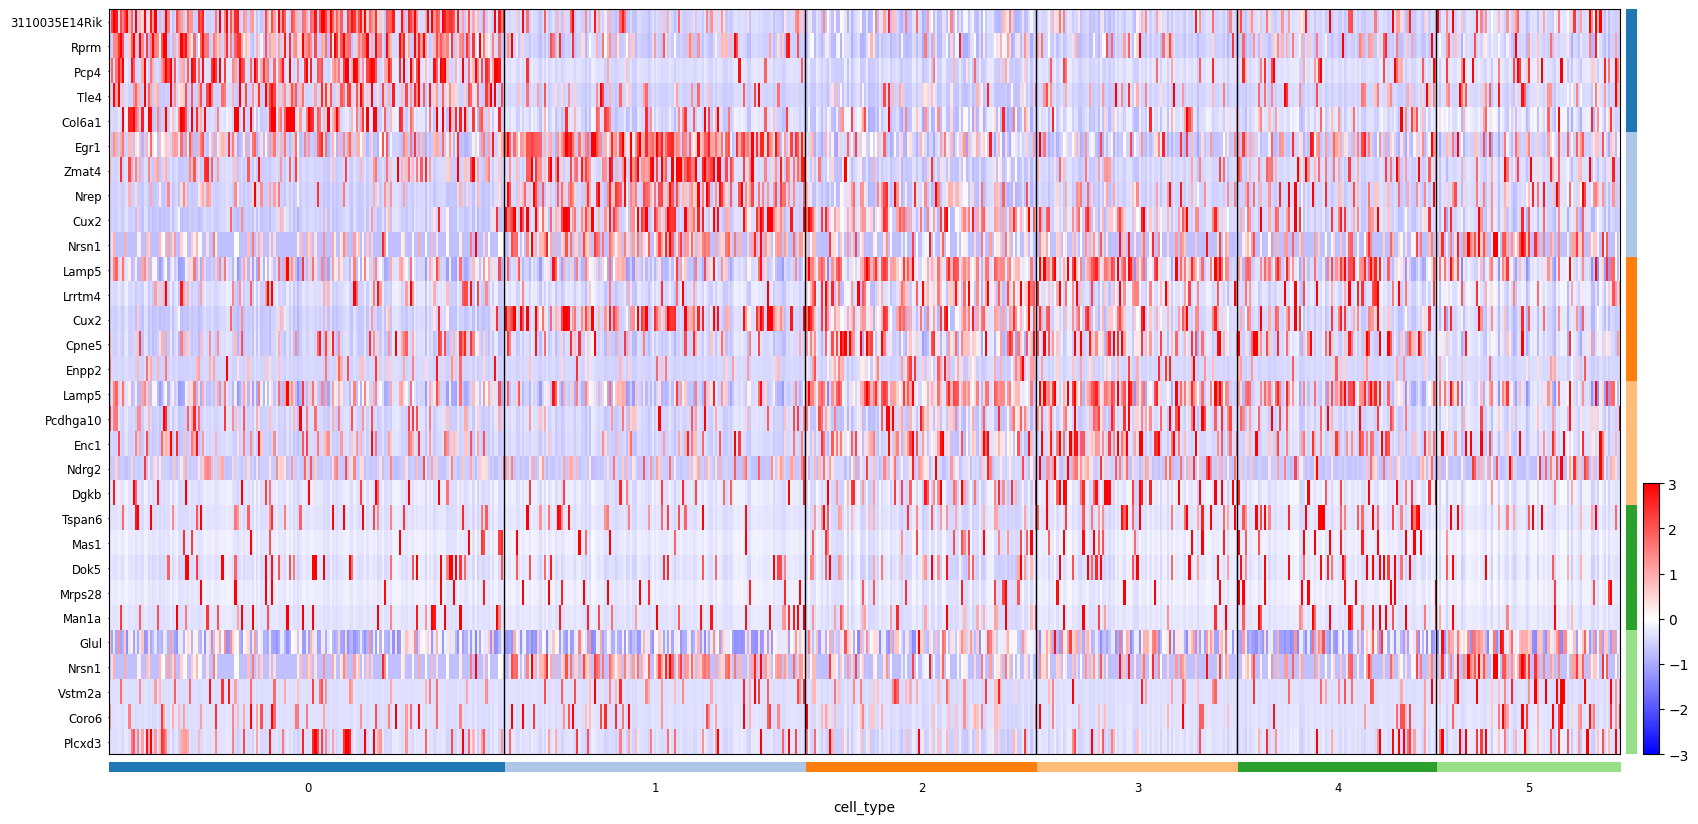

0 ['3110035E14Rik', 'Rprm', 'Pcp4', 'Tle4', 'Col6a1']
1 ['Egr1', 'Zmat4', 'Bcl6', 'Nrep', 'Cux2']
2 ['Lamp5', 'Lrrtm4', 'Cux2', 'Camk2n1', 'Cpne5']
3 ['Camk2n1', 'Lamp5', 'Camk2a', 'Pcdhga10', 'Enc1']
4 ['Mal2', 'Atp9a', 'Fbxw11', 'Slc6a15', 'Ppp3cb']
5 ['Tsnax', 'Glul', 'Nrsn1', 'Cplx1', 'Kif5a']


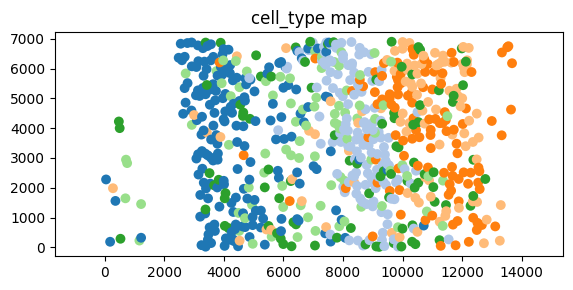

In [17]:
cluster_pl=model.plot_cell_typing(use_adata=model.exci_adata,
                                  umap=True,
                                  heatmap=True, 
                                  print_markers=True,
                                  celltypemap=True)


0: eL6
1: eL4
2: eL2/3-1
3: eL2/3-2
4: Others
5: eL5

2. Inhibitory neurons

In [18]:
model.inhi_adata=model.cell_adata[model.cell_adata.obs['cell_type']==2,:]

In [19]:
model.cell_typing(use_adata=model.inhi_adata,
                  cluster_method='leiden',resol=0.5)

Trying to set attribute `.obs` of view, copying.


clustering method: leiden
Leiden clustering
Get 3 clusters


/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


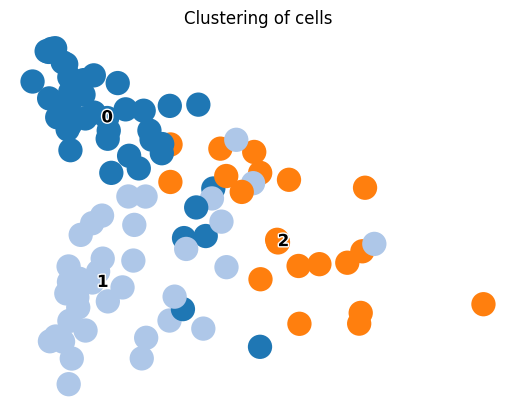

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


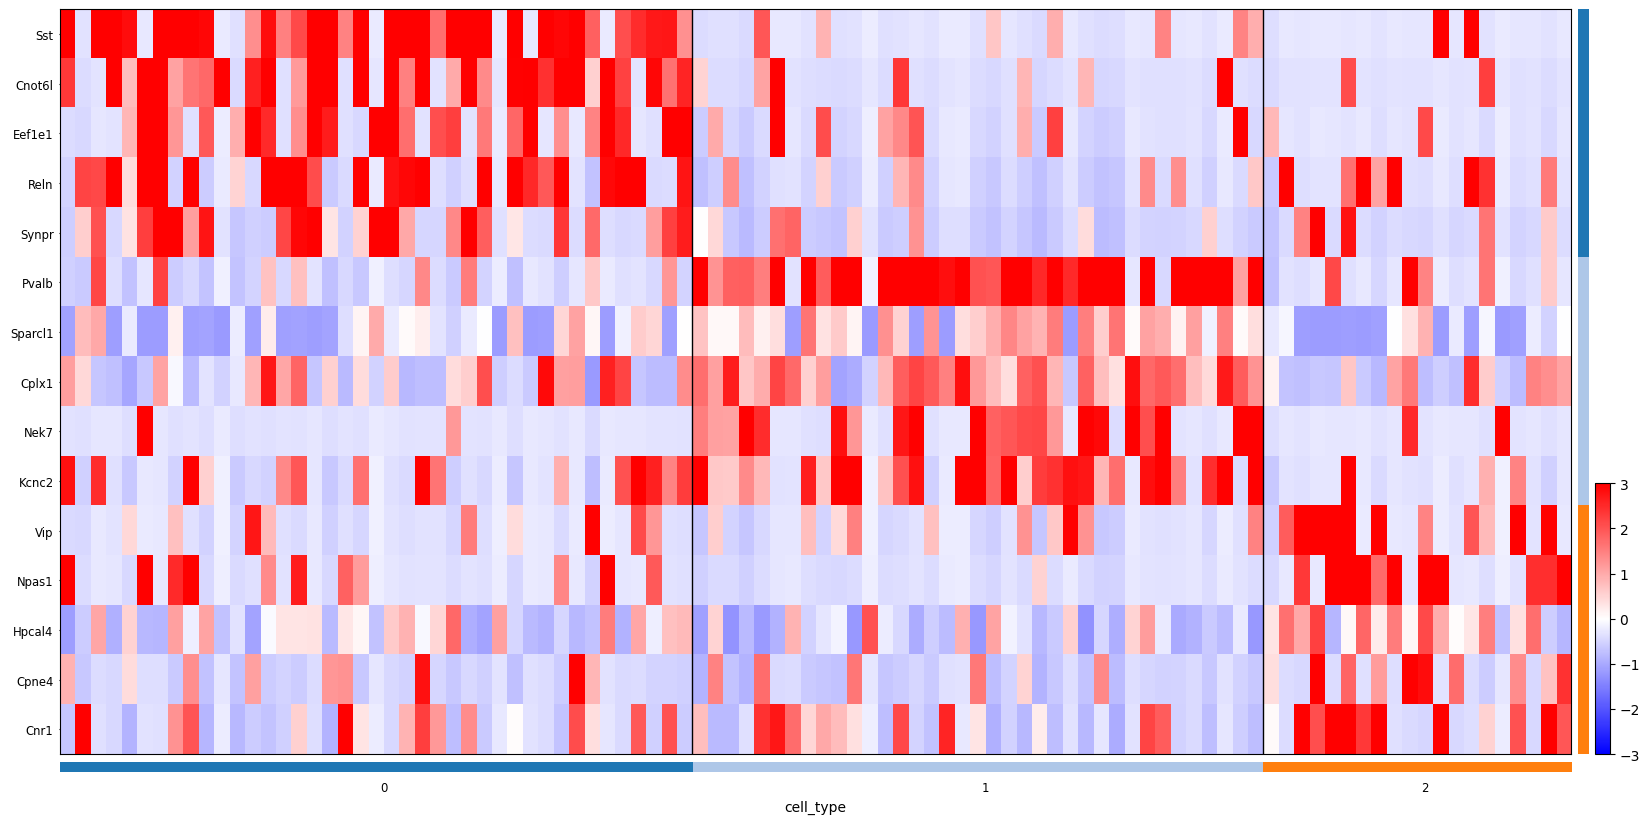

0 ['Sst', 'Cnot6l', 'Eef1e1', 'Reln', 'Synpr']
1 ['Pvalb', 'Sparcl1', 'Cplx1', 'Nek7', 'Kcnc2']
2 ['Vip', 'Npas1', 'Hpcal4', 'Cpne4', 'Cnr1']


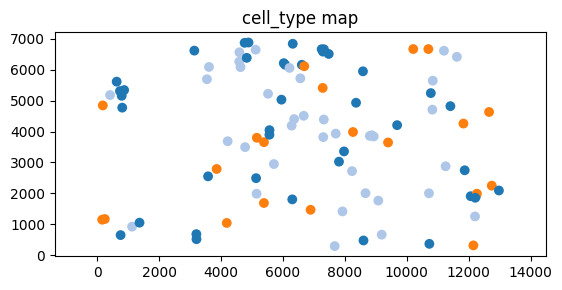

In [20]:
cluster_pl=model.plot_cell_typing(use_adata=model.inhi_adata,
                                  umap=True,
                                  heatmap=True, 
                                  print_markers=True,
                                  celltypemap=True)


0:Sst
1:Pv
2:Vip

3. Non-neuronal cells

In [21]:
model.nonn_adata=model.cell_adata[model.cell_adata.obs['cell_type']==1,:]

In [22]:
model.cell_typing(use_adata=model.nonn_adata,
                  cluster_method='leiden',resol=0.65)

Trying to set attribute `.obs` of view, copying.


clustering method: leiden
Leiden clustering
Get 5 clusters


/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


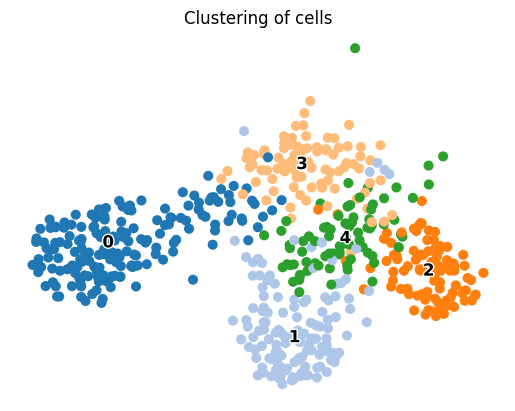

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2406: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


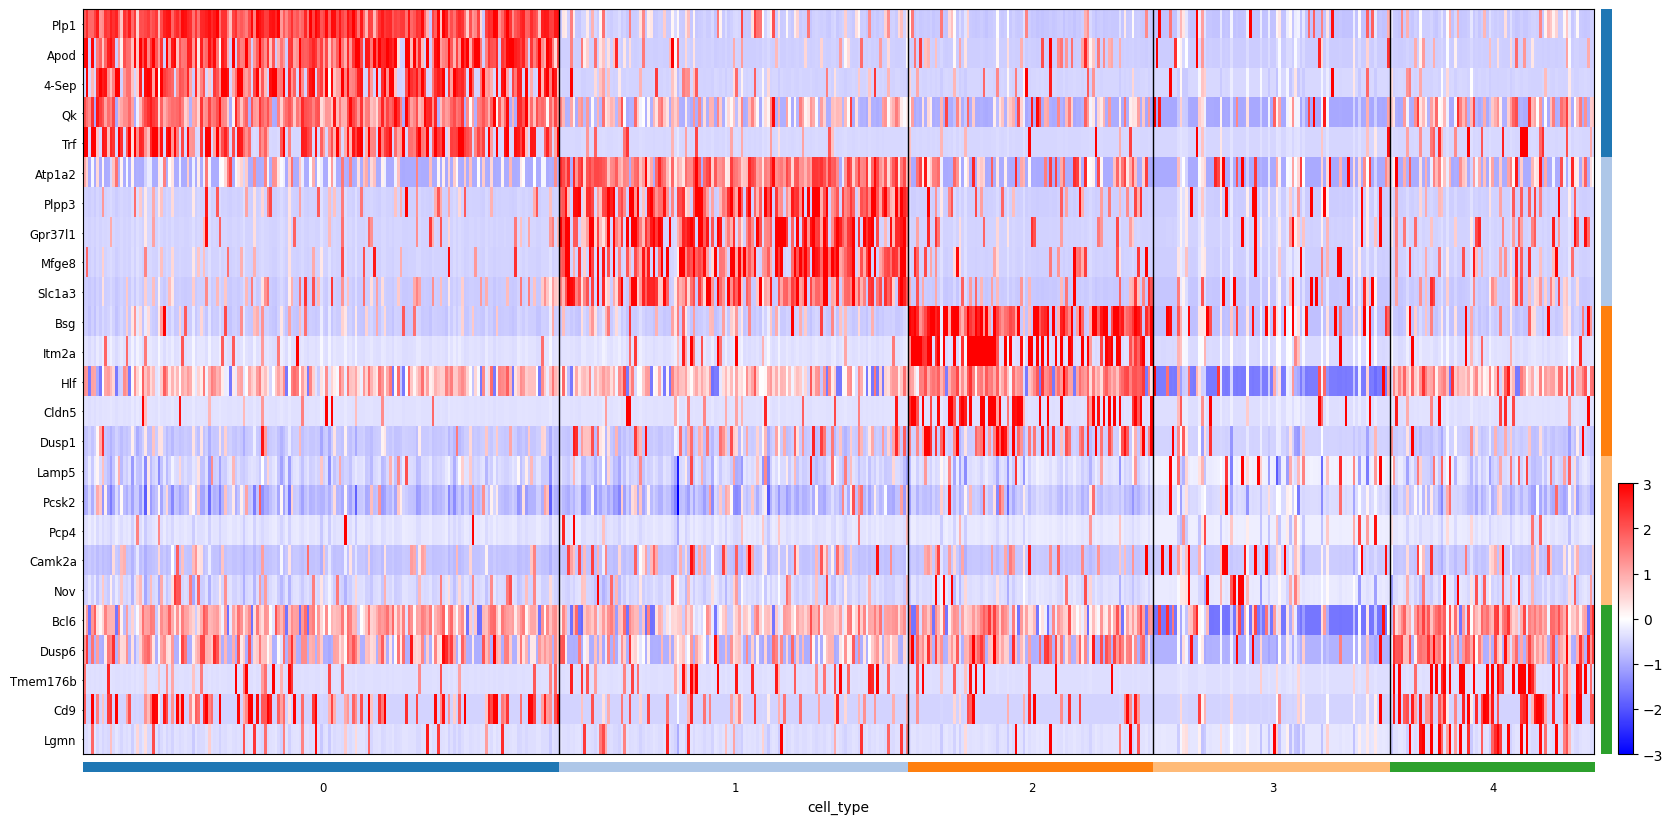

0 ['Plp1', 'Apod', '4-Sep', 'Qk', 'Trf']
1 ['Atp1a2', 'Plpp3', 'Gpr37l1', 'Mfge8', 'Slc1a3']
2 ['Bsg', 'Itm2a', 'Hlf', 'Cldn5', 'Dusp1']
3 ['Lamp5', 'Pcsk2', 'Pcp4', 'Camk2a', 'Nov']
4 ['Bcl6', 'Dusp6', 'Tmem176b', 'Tsnax', 'Hlf']


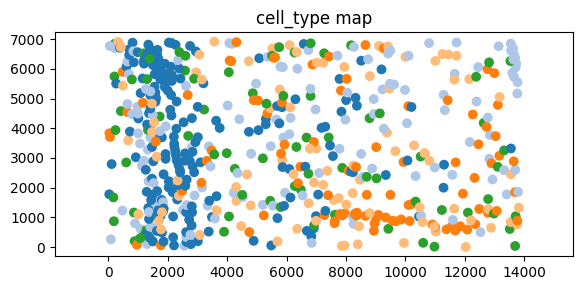

In [23]:
cluster_pl=model.plot_cell_typing(use_adata=model.nonn_adata,
                                  umap=True,
                                  heatmap=True, 
                                  print_markers=True,
                                  celltypemap=True)


In [24]:
###combine sub-clustering results
model.combine_cell_type([model.exci_adata,model.inhi_adata,model.nonn_adata])

In [25]:
model.map_cell_type_to_spots(cellid)

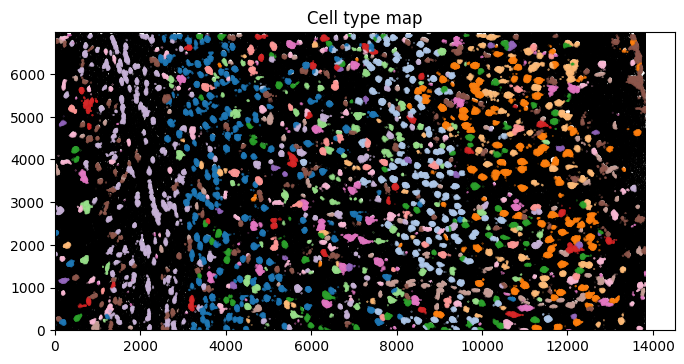

In [26]:
### plot cell segmentation results in spots (colored by cells)
cmap=sns.color_palette('tab20',20)
model.plot_segmentation(figsize=(8,8),method='cell_type',s=0.005,plot_with_dapi=True,plot_dapi=True, show=False,cmap=np.array(cmap))
plt.title('Cell type map')
plt.show()

### Tissue region identification

/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/mnt/c/Users/shach/OneDrive/Desktop/Stellaromics/Code/ClusterMap/ClusterMap_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


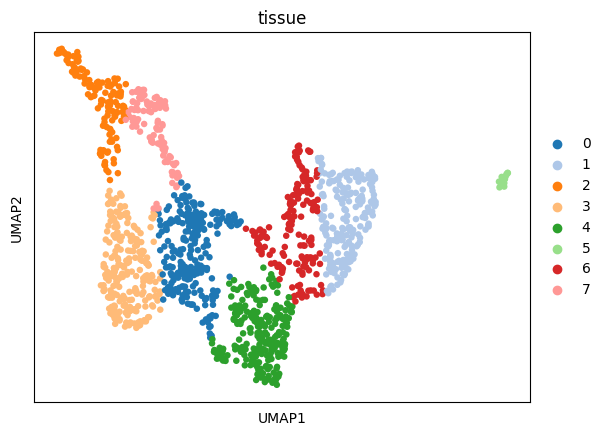

In [27]:
model.compute_ncc(tissue_radius=400,n_neighbors=20)
model.tissue_identify(region=8,cmap=cmap)

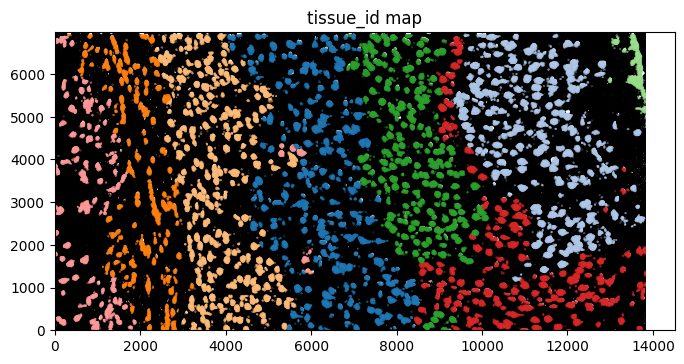

In [28]:
### plot tissue region results in spots (colored by cells)
model.map_cell_type_to_spots(cellid,target_name='tissue_id')
model.plot_segmentation(figsize=(8,8),method='tissue_id',s=0.005,plot_with_dapi=True,plot_dapi=True, show=False,
                       cmap=np.array(cmap))
plt.title('tissue_id map')
plt.show()

Note: Region 3 is separate from region 2 because of some mixed vascular cells.